In [1]:
from tensorflow.keras import layers, Model, backend as K
from tensorflow.keras import backend as K 
from tensorflow.keras.layers import Layer
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dropout, Dense, LSTM, Concatenate, Flatten, Conv1D
from tensorflow.keras.models import Sequential
from kerashypetune import KerasGridSearch
from models import T2V


# Data Manipulation
import numpy as np
import pandas as pd
from numpy import array
from numpy import dstack
from numpy import unique
from pandas import read_csv
from matplotlib import pyplot

In [12]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files, such as x, y, z data for a given variable
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

# get all data for one subject
def data_for_subject(X, y, sub_map, sub_id):
    # get row indexes for the subject id
    ix = [i for i in range(len(sub_map)) if sub_map[i]==sub_id]
    # return the selected samples
    return X[ix, :, :], y[ix]

# convert a series of windows to a 1D list
def to_series(windows):
    series = list()
    for window in windows:
        # remove the overlap from the window
        half = int(len(window) / 2) - 1
        for value in window[-half:]:
            series.append(value)
    return series

# group data by activity
def data_by_activity(X, y, activities):
    # group windows by activity
    return {a:X[y[:,0]==a, :, :] for a in activities}

# plot histograms for each activity for a subject
def plot_activity_histograms(X, y):
    # get a list of unique activities for the subject
    activity_ids = unique(y[:,0])
    # group windows by activity
    grouped = data_by_activity(X, y, activity_ids)
    # plot per activity, histograms for each axis
    pyplot.figure()
    xaxis = None
    for k in range(len(activity_ids)):
        act_id = activity_ids[k]
        # total acceleration
        for i in range(3):
            ax = pyplot.subplot(len(activity_ids), 1, k+1, sharex=xaxis)
            ax.set_xlim(-1,1)
            if k == 0:
                xaxis = ax
            pyplot.hist(to_series(grouped[act_id][:,:,i]), bins=100)
            pyplot.title('activity '+str(act_id), y=0, loc='left')
    pyplot.show()

In [13]:
# load all train
X_train, y_train = load_dataset('train', '/Users/pranavtushar/Documents/time-series/HARDataset/')
print(X_train.shape, y_train.shape)

# load all test
X_test, y_test = load_dataset('test', '/Users/pranavtushar/Documents/time-series/HARDataset/')
print(X_test.shape, y_test.shape)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)


In [2]:
class Sine(tf.keras.layers.Layer):
    def __init__(self, w0: float = 1.0, **kwargs):
        """
        Sine activation function with learnable w0 scaling support.
        Args:
            w0: w0 in the activation step `act(x; w0) = sin(w0 * x)`
        """
        super(Sine, self).__init__(**kwargs)
        #self.w0 = w0
    
    def build(self, input_shape):
        self.w0 = self.add_weight(shape=(1,),
                             initializer='ones',
                             trainable=True)

    def call(self, inputs):
        return tf.sin(self.w0 * inputs)
    
    def get_config(self):
        config = {'w0': self.w0}
        base_config = super(Sine, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [3]:
def Neural_time2vec():
    inp = layers.Input(shape=(128,9))
    x1 = LSTM(32, activation='relu')(inp)
    x1 = Dense(64)(x1)
    x1 = Dense(32)(x1)
    x2 = LSTM(32)(inp)
    x2 = Sine()(x2)
    x2 = Dense(64)(x2)
    x2 = Sine()(x2)
    x2 = Dense(32)(x2)
    x2 = Sine()(x2)
    x = Concatenate()([x1, x2])
    x = Dropout(0.2)(x)
    x = Dense(1)(x)
    model = Model(inp, x)
    model.compile(loss='mse', optimizer='adam')
    #model.summary()
    #tf.keras.utils.plot_model(model, show_shapes=True)
    return model

In [4]:
def time2vec_lstm_baseline():
    inp = layers.Input(shape=(128, 9))
    x = T2V(64)(inp)
    x = LSTM(32, activation='relu')(x)
    x = Dense(64)(x)
    x = Dense(32)(x)
    x = Dropout(0.2)(x)
    x = Dense(1)(x)
    model = Model(inp, x)
    model.compile(loss='mse', optimizer='adam')
    #model.summary()
    #tf.keras.utils.plot_model(model, show_shapes=True)
    return model

In [5]:
def lstm_baseline():
    inp = layers.Input(shape=(128, 9))
    x = LSTM(32, activation='relu')(inp)
    x = Dense(64)(x)
    x = Dense(32)(x)
    x = Dropout(0.2)(x)
    x = Dense(1)(x)
    model = Model(inp, x)
    model.compile(loss='mse', optimizer='adam')
    #model.summary()
    #tf.keras.utils.plot_model(model, show_shapes=True)
    return model

# MODEL


In [6]:
lstm_model = lstm_baseline()

In [7]:
time2vec_model = time2vec_lstm_baseline()

In [8]:
neural_time2vec_model = Neural_time2vec()

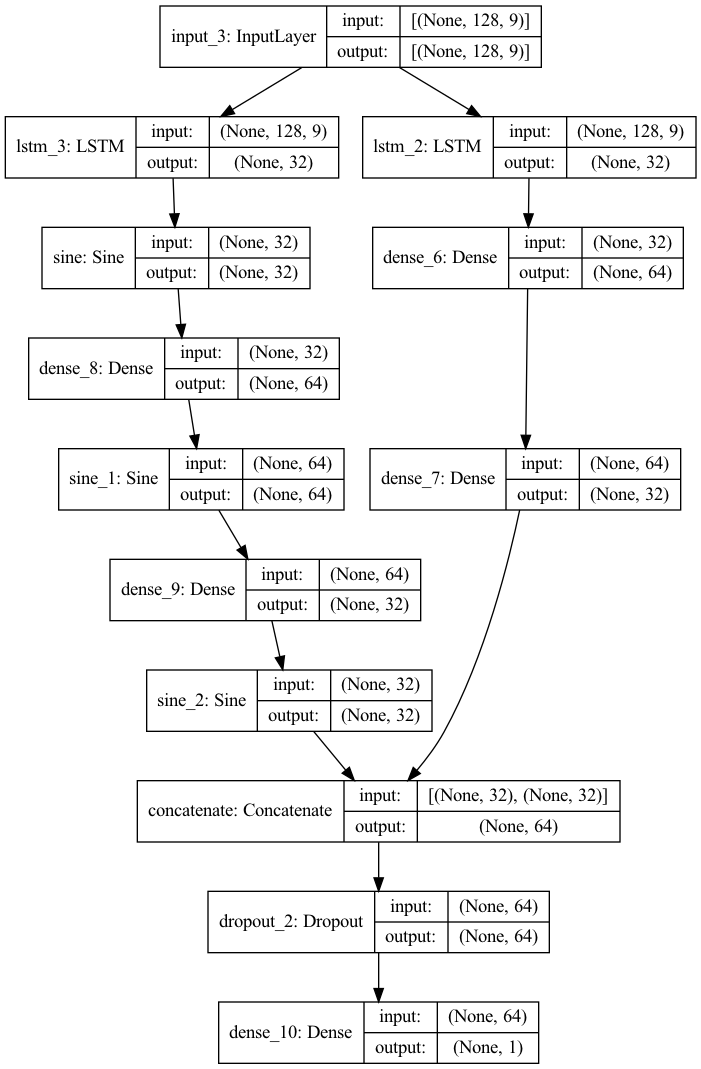

In [9]:
tf.keras.utils.plot_model(neural_time2vec_model, show_shapes=True)

In [14]:
# Training
history_lstm = lstm_model.fit(X_train, y_train, epochs=10, validation_split=0.2, shuffle=False, batch_size=16, verbose=1)

Epoch 1/10
368/368 [==============================] - 9s 24ms/step - loss: 4.4889 - val_loss: 1.5857
Epoch 2/10
368/368 [==============================] - 8s 23ms/step - loss: 0.9944 - val_loss: 0.8943
Epoch 3/10
368/368 [==============================] - 8s 22ms/step - loss: 0.5853 - val_loss: 0.9165
Epoch 4/10
368/368 [==============================] - 9s 24ms/step - loss: 0.5225 - val_loss: 0.6844
Epoch 5/10
368/368 [==============================] - 9s 24ms/step - loss: 0.4217 - val_loss: 0.6104
Epoch 6/10
368/368 [==============================] - 9s 24ms/step - loss: 0.3981 - val_loss: 0.5749
Epoch 7/10
368/368 [==============================] - 9s 24ms/step - loss: 0.3607 - val_loss: 0.5936
Epoch 8/10
368/368 [==============================] - 9s 25ms/step - loss: 0.3327 - val_loss: 0.5605
Epoch 9/10
368/368 [==============================] - 9s 25ms/step - loss: 0.3312 - val_loss: 0.5604
Epoch 10/10
368/368 [==============================] - 9s 24ms/step - loss: 0.2836 - val_lo

In [15]:
history_t2v = time2vec_model.fit(X_train, y_train, epochs=10, validation_split=0.2, shuffle=False, batch_size=16, verbose=1)


Epoch 1/10
368/368 [==============================] - 11s 27ms/step - loss: 4477868512.8673 - val_loss: 2.0416
Epoch 2/10
368/368 [==============================] - 11s 30ms/step - loss: 1.7238 - val_loss: 1.7539
Epoch 3/10
368/368 [==============================] - 10s 27ms/step - loss: 1.5055 - val_loss: 1.5672
Epoch 4/10
368/368 [==============================] - 10s 28ms/step - loss: 1.3976 - val_loss: 0.9898
Epoch 5/10
368/368 [==============================] - 10s 28ms/step - loss: 23907.8278 - val_loss: 2.8955
Epoch 6/10
368/368 [==============================] - 10s 28ms/step - loss: 2.3770 - val_loss: 2.4325
Epoch 7/10
368/368 [==============================] - 10s 28ms/step - loss: 2.1080 - val_loss: 2.2413
Epoch 8/10
368/368 [==============================] - 10s 28ms/step - loss: 1.9729 - val_loss: 2.1153
Epoch 9/10
368/368 [==============================] - 10s 28ms/step - loss: 1.8365 - val_loss: 2.0299
Epoch 10/10
368/368 [==============================] - 11s 29ms/step 

In [16]:
history_neural_t2v = neural_time2vec_model.fit(X_train, y_train, epochs=10, validation_split=0.2, shuffle=False, batch_size=16, verbose=1)

Epoch 1/10
368/368 [==============================] - 13s 32ms/step - loss: 18023854.6718 - val_loss: 3.3899
Epoch 2/10
368/368 [==============================] - 11s 31ms/step - loss: 47.7385 - val_loss: 4.0432
Epoch 3/10
368/368 [==============================] - 12s 33ms/step - loss: 3.5132 - val_loss: 3.5788
Epoch 4/10
368/368 [==============================] - 12s 33ms/step - loss: 3.0466 - val_loss: 2.9083
Epoch 5/10
368/368 [==============================] - 12s 32ms/step - loss: 2.4309 - val_loss: 2.5005
Epoch 6/10
368/368 [==============================] - 12s 32ms/step - loss: 1.9564 - val_loss: 2.2565
Epoch 7/10
368/368 [==============================] - 12s 31ms/step - loss: 1.5700 - val_loss: 1.9632
Epoch 8/10
368/368 [==============================] - 12s 32ms/step - loss: 1.3187 - val_loss: 1.6203
Epoch 9/10
368/368 [==============================] - 12s 31ms/step - loss: 1.0456 - val_loss: 1.5230
Epoch 10/10
368/368 [==============================] - 11s 31ms/step - los

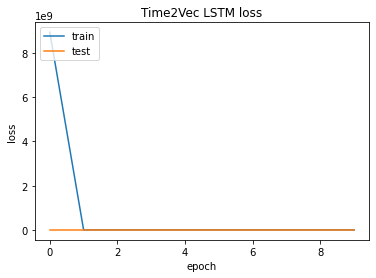

In [25]:
plt.plot(history_t2v.history['loss'])
plt.plot(history_t2v.history['val_loss'])
plt.title('Time2Vec LSTM loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

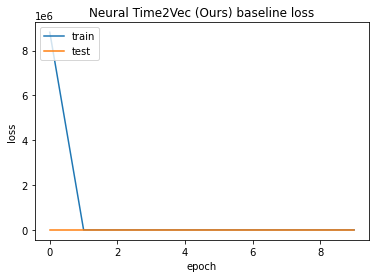

In [26]:
plt.plot(history_neural_t2v.history['loss'])
plt.plot(history_neural_t2v.history['val_loss'])
plt.title('Neural Time2Vec (Ours) baseline loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

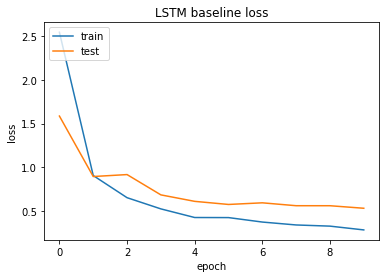

In [27]:
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('LSTM baseline loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
lstm_model.evaluate(X_test, y_test)

93/93 [==============================] - 1s 6ms/step - loss: 0.3559


0.3559100925922394

In [29]:
time2vec_model.evaluate(X_test, y_test)

93/93 [==============================] - 1s 7ms/step - loss: 1.6954


1.6953550577163696

In [30]:
neural_time2vec_model.evaluate(X_test, y_test)

93/93 [==============================] - 1s 7ms/step - loss: 0.9792


0.9792123436927795

In [31]:
item = "HAR DATASET"

In [32]:
def predict_and_plot(model, X_test, model_name, item):
    y_hat = model.predict(X_test)
    plt.plot(y_test, label=f"Actual {item}", color='green')
    plt.plot(y_hat, label=f"Predicted {item}", color='red')

    plt.title(f'{item} prediction with {model_name}')
    plt.xlabel('Time [days]')
    plt.ylabel(f'{item}')
    plt.legend(loc='best')
    plt.show()

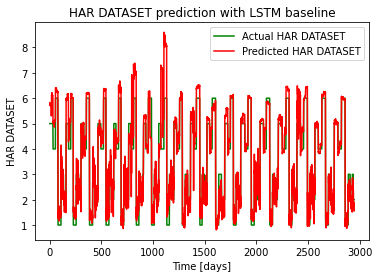

In [33]:
predict_and_plot(lstm_model, X_test, "LSTM baseline", item)

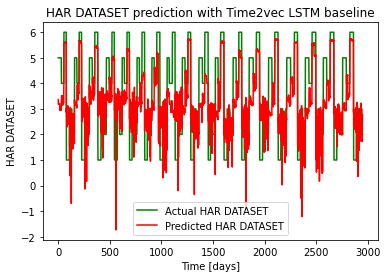

In [34]:
predict_and_plot(time2vec_model, X_test, "Time2vec LSTM baseline", item)

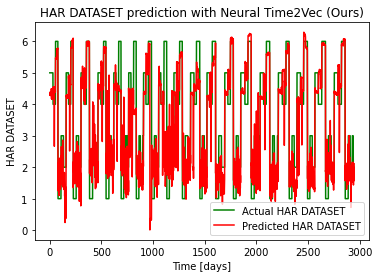

In [35]:
predict_and_plot(neural_time2vec_model, X_test, "Neural Time2Vec (Ours)", item)

### Inference 1: 

**This low training data case shows that few-shot time series forecasting is not possible with embeddings that start from scratch. To make it a reality, we need to develop pre-trained embeddings for Time-series**

In [ ]:
model.summary()